In [2]:
import json
import nltk
import random 
import time
import string
import pickle
import numpy as np
import pandas as pd
from gtts import gTTS
from io import BytesIO
import tensorflow as tf
import IPython.display as ipd
import speech_recognition as sr 
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Model,load_model
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten, Dense, GlobalMaxPool1D


In [32]:
with open('intents.json') as content2:
    data2=json.load(content2)
    
    

In [33]:
tags=[]
inputs=[]
responses={}
words=[]
classes=[]
documents=[]
ignore_words=['?','!']

for intent in data2['intents']:
    responses[intent['tag']]=intent['responses']
    for lines in intent['patterns']:
        inputs.append(lines)
        tags.append(intent['tag'])
        for pattern in intent['patterns']:
            w=nltk.word_tokenize(pattern)
            words.extend(w)
            documents.append((w,intent['tag']))
            if intent['tag'] not in classes:
                classes.append(intent['tag'])
data=pd.DataFrame({"patterns":inputs,"tags":tags})

In [34]:

data

,patterns,tags
0,hello,greetings
1,hey,greetings
2,hi,greetings
3,goodday,greetings
4,Greetings,greetings
5,What's up,greetings
6,how is it going,greetings
7,cya,goodbye
8,See you latter,goodbye
9,Goodbye,goodbye


In [35]:
data['patterns']=data['patterns'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['patterns']=data['patterns'].apply(lambda wrd:''.join(wrd))

In [5]:
lemmatizer = WordNetLemmatizer()

In [37]:
words=[lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words=sorted(list(set(words)))

In [38]:
print(len(words),words)

58 ["'s", 'a', 'age', 'am', 'are', 'buy', 'bye', 'call', 'can', 'cao', 'company', 'coureses', 'cya', 'day', 'developed', 'going', 'good', 'goodbye', 'goodday', 'greeting', 'guy', 'have', 'hello', 'hey', 'hi', 'hour', 'how', 'i', 'id', 'investing', 'is', 'it', 'latter', 'leaving', 'like', 'my', 'name', 'of', 'old', 'open', 'opening', 'own', 'recommend', 'see', 'share', 'should', 'somethings', 'stock', 'studying', 'subject', 'tell', 'to', 'up', 'what', 'when', 'who', 'you', 'your']


In [39]:
classes=sorted(list(set(classes)))
print(len(classes),classes)

9 ['Subject', 'YOU', 'age', 'goodbye', 'greetings ', 'hours', 'name', 'shop', 'stocks']


In [40]:
print(len(documents))

184


In [41]:
tokenizer=Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['patterns'])
train=tokenizer.texts_to_sequences(data['patterns'])

In [42]:
train

[[19],
 [20],
 [21],
 [22],
 [23],
 [24, 25],
 [6, 7, 26, 27],
 [28],
 [29, 2, 30],
 [31],
 [3, 9, 32],
 [33, 34, 35, 36],
 [37],
 [38],
 [1, 7, 5, 8],
 [1, 10, 3, 39, 2],
 [11, 4, 2],
 [40, 2, 41, 5, 8],
 [1, 7, 5, 8],
 [6, 12],
 [6, 12, 4, 2],
 [1, 7, 5, 13],
 [13],
 [42, 43, 44, 45, 14],
 [1, 10, 3, 14],
 [1, 10, 3, 46],
 [47, 4, 2, 48, 49],
 [1, 4, 5, 15],
 [15, 50, 51],
 [1, 52, 3, 16],
 [6, 4, 17, 53],
 [1, 54, 9, 3, 55],
 [1, 18, 3, 16],
 [6, 4, 17, 56],
 [1, 18, 9, 3, 57],
 [11, 4, 2],
 [11, 58, 2],
 [1, 7, 5, 8]]

In [43]:
X_train=pad_sequences(train)

In [44]:
X_train

array([[ 0,  0,  0,  0, 19],
       [ 0,  0,  0,  0, 20],
       [ 0,  0,  0,  0, 21],
       [ 0,  0,  0,  0, 22],
       [ 0,  0,  0,  0, 23],
       [ 0,  0,  0, 24, 25],
       [ 0,  6,  7, 26, 27],
       [ 0,  0,  0,  0, 28],
       [ 0,  0, 29,  2, 30],
       [ 0,  0,  0,  0, 31],
       [ 0,  0,  3,  9, 32],
       [ 0, 33, 34, 35, 36],
       [ 0,  0,  0,  0, 37],
       [ 0,  0,  0,  0, 38],
       [ 0,  1,  7,  5,  8],
       [ 1, 10,  3, 39,  2],
       [ 0,  0, 11,  4,  2],
       [40,  2, 41,  5,  8],
       [ 0,  1,  7,  5,  8],
       [ 0,  0,  0,  6, 12],
       [ 0,  6, 12,  4,  2],
       [ 0,  1,  7,  5, 13],
       [ 0,  0,  0,  0, 13],
       [42, 43, 44, 45, 14],
       [ 0,  1, 10,  3, 14],
       [ 0,  1, 10,  3, 46],
       [47,  4,  2, 48, 49],
       [ 0,  1,  4,  5, 15],
       [ 0,  0, 15, 50, 51],
       [ 0,  1, 52,  3, 16],
       [ 0,  6,  4, 17, 53],
       [ 1, 54,  9,  3, 55],
       [ 0,  1, 18,  3, 16],
       [ 0,  6,  4, 17, 56],
       [ 1, 18

In [6]:
le=LabelEncoder()
y_train=le.fit_transform(data['tags'])

NameError: name 'data' is not defined

In [46]:
y_train

array([4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 6, 6, 6, 6, 6, 2, 2, 2,
       2, 7, 7, 7, 5, 5, 5, 8, 8, 8, 0, 0, 0, 1, 1, 1])

In [47]:
input_shape=X_train.shape[1]

In [48]:
input_shape

5

In [49]:
vocabulary=len(tokenizer.word_index)
print("Number of unique words : ",vocabulary)

output_length=le.classes_.shape[0]
print("output length :",output_length)

Number of unique words :  58
output length : 9


In [50]:
pickle.dump(words,open('words.pkl','wb'))
pickle.dump(classes,open('classes.pkl','wb'))

In [51]:
pickle.dump(le,open('le.pkl','wb'))
pickle.dump(tokenizer,open('tokenizer.pkl','wb'))

In [52]:
i=Input(shape=(input_shape,))
x=Embedding(vocabulary+1,10)(i)
x=LSTM(10,return_sequences=True)(x)
x=Flatten()(x)
x=Dense(output_length,activation="softmax")(x)
model=Model(i,x)

model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [53]:
plot_model(model, to_file='model_plot.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [54]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5)]               0         
                                                                 
 embedding_1 (Embedding)     (None, 5, 10)             590       
                                                                 
 lstm_1 (LSTM)               (None, 5, 10)             840       
                                                                 
 flatten_1 (Flatten)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 9)                 459       
                                                                 
Total params: 1,889
Trainable params: 1,889
Non-trainable params: 0
_________________________________________________________________


In [55]:
train=model.fit(X_train,y_train,epochs=400)

Epoch 1/400
2/2 [==============================] - 2s 9ms/step - loss: 2.1996 - accuracy: 0.0789
Epoch 2/400
2/2 [==============================] - 0s 9ms/step - loss: 2.1968 - accuracy: 0.1842
Epoch 3/400
2/2 [==============================] - 0s 9ms/step - loss: 2.1947 - accuracy: 0.1842
Epoch 4/400
2/2 [==============================] - 0s 9ms/step - loss: 2.1923 - accuracy: 0.2368
Epoch 5/400
2/2 [==============================] - 0s 11ms/step - loss: 2.1903 - accuracy: 0.1842
Epoch 6/400
2/2 [==============================] - 0s 10ms/step - loss: 2.1882 - accuracy: 0.1842
Epoch 7/400
2/2 [==============================] - 0s 10ms/step - loss: 2.1862 - accuracy: 0.1842
Epoch 8/400
2/2 [==============================] - 0s 11ms/step - loss: 2.1838 - accuracy: 0.1842
Epoch 9/400
2/2 [==============================] - 0s 10ms/step - loss: 2.1817 - accuracy: 0.1579
Epoch 10/400
2/2 [==============================] - 0s 10ms/step - loss: 2.1795 - accuracy: 0.1842
Epoch 11/400
2/2 [=====

2/2 [==============================] - 0s 7ms/step - loss: 1.5612 - accuracy: 0.5526
Epoch 85/400
2/2 [==============================] - 0s 8ms/step - loss: 1.5529 - accuracy: 0.5526
Epoch 86/400
2/2 [==============================] - 0s 6ms/step - loss: 1.5449 - accuracy: 0.5526
Epoch 87/400
2/2 [==============================] - 0s 7ms/step - loss: 1.5370 - accuracy: 0.5526
Epoch 88/400
2/2 [==============================] - 0s 6ms/step - loss: 1.5291 - accuracy: 0.5526
Epoch 89/400
2/2 [==============================] - 0s 6ms/step - loss: 1.5217 - accuracy: 0.5526
Epoch 90/400
2/2 [==============================] - 0s 7ms/step - loss: 1.5136 - accuracy: 0.5526
Epoch 91/400
2/2 [==============================] - 0s 6ms/step - loss: 1.5059 - accuracy: 0.5526
Epoch 92/400
2/2 [==============================] - 0s 6ms/step - loss: 1.4982 - accuracy: 0.5526
Epoch 93/400
2/2 [==============================] - 0s 6ms/step - loss: 1.4903 - accuracy: 0.5526
Epoch 94/400
2/2 [===============

2/2 [==============================] - 0s 13ms/step - loss: 0.4770 - accuracy: 0.8947
Epoch 249/400
2/2 [==============================] - 0s 15ms/step - loss: 0.4738 - accuracy: 0.8947
Epoch 250/400
2/2 [==============================] - 0s 13ms/step - loss: 0.4724 - accuracy: 0.8947
Epoch 251/400
2/2 [==============================] - 0s 14ms/step - loss: 0.4698 - accuracy: 0.8947
Epoch 252/400
2/2 [==============================] - 0s 14ms/step - loss: 0.4665 - accuracy: 0.8947
Epoch 253/400
2/2 [==============================] - 0s 14ms/step - loss: 0.4630 - accuracy: 0.8947
Epoch 254/400
2/2 [==============================] - 0s 14ms/step - loss: 0.4593 - accuracy: 0.8947
Epoch 255/400
2/2 [==============================] - 0s 13ms/step - loss: 0.4556 - accuracy: 0.8947
Epoch 256/400
2/2 [==============================] - 0s 14ms/step - loss: 0.4521 - accuracy: 0.8947
Epoch 257/400
2/2 [==============================] - 0s 13ms/step - loss: 0.4493 - accuracy: 0.8947
Epoch 258/400


2/2 [==============================] - 0s 13ms/step - loss: 0.2948 - accuracy: 0.8947
Epoch 331/400
2/2 [==============================] - 0s 14ms/step - loss: 0.2934 - accuracy: 0.8947
Epoch 332/400
2/2 [==============================] - 0s 13ms/step - loss: 0.2922 - accuracy: 0.8947
Epoch 333/400
2/2 [==============================] - 0s 14ms/step - loss: 0.2908 - accuracy: 0.8947
Epoch 334/400
2/2 [==============================] - 0s 14ms/step - loss: 0.2892 - accuracy: 0.8947
Epoch 335/400
2/2 [==============================] - 0s 11ms/step - loss: 0.2879 - accuracy: 0.8947
Epoch 336/400
2/2 [==============================] - 0s 13ms/step - loss: 0.2862 - accuracy: 0.8947
Epoch 337/400
2/2 [==============================] - 0s 13ms/step - loss: 0.2857 - accuracy: 0.8947
Epoch 338/400
2/2 [==============================] - 0s 14ms/step - loss: 0.2842 - accuracy: 0.8947
Epoch 339/400
2/2 [==============================] - 0s 14ms/step - loss: 0.2838 - accuracy: 0.9211
Epoch 340/400


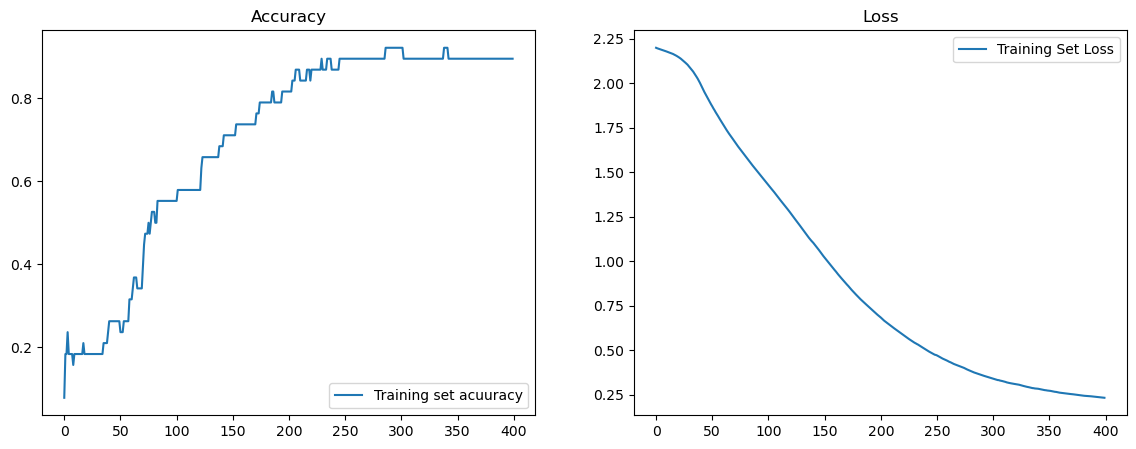

In [57]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(train.history['accuracy'],label="Training set acuuracy")
plt.legend(loc='lower right')
plt.title('Accuracy')
# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(train.history['loss'],label='Training Set Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

In [58]:
while True:
    texts_p = []
    prediction_input = input('👨‍🦰 YOU : ')
  
  # Menghapus punktuasi dan konversi ke huruf kecil
    prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
    prediction_input = ''.join(prediction_input)
    texts_p.append(prediction_input)

  # Tokenisasi dan Padding
    prediction_input = tokenizer.texts_to_sequences(texts_p)
    prediction_input = np.array(prediction_input).reshape(-1)
    prediction_input = pad_sequences([prediction_input],input_shape)

  # Mendapatkan hasil keluaran pada model 
    output = model.predict(prediction_input)
    output = output.argmax()

  # Menemukan respon sesuai data tag dan memainkan voice bot
    response_tag = le.inverse_transform([output])[0]
    print("🤖 AIBot : ", random.choice(responses[response_tag]))
    #tts = gTTS(random.choice(responses[response_tag]), lang='id')
  # Simpan model voice bot ke dalam Google Drive
    #tts.save('KadekBot.wav')
    #time.sleep(0.08)
  # Load model voice bot from Google Drive
    #ipd.display(ipd.Audio('KadekBot.wav', autoplay=False))
    #print("="*60 + "\n")
  # Tambahkan respon 'goodbye' agar bot bisa berhenti
    if response_tag == "goodbye":
        break 

👨‍🦰 YOU : ji
1/1 [==============================] - 0s 374ms/step
🤖 AIBot :  Talk you later


In [3]:
model1=load_model('chat_2.h5')

2023-02-25 12:27:52.809503: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-25 12:27:52.809573: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-25 12:27:52.809637: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kali): /proc/driver/nvidia/version does not exist
2023-02-25 12:27:52.810251: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
while True:
    texts_p=[]
    prediction_input=input("YOU :")
    
    prediction_input=[letters.lower() for letters in prediction_input if letters not in string.punctuation]
    prediction_input=" ".join(prediction_input)
    texts_p.append(prediction_input)
    
    prediction_input=tokenizer.texts_to_sequences(texts_p)
    prediction_input=np.array(prediction_input).reshape(-1)
    prediction_input=pad_sequences([prediction_input],9)
    output=model1.predict(prediction_input)
    output=output.argmax()
    response_tag=le.inverse_transform([output])[0]
    print("BOT :",random.choice(responses[response_tag]))
    if response_tag=="goobye":
        break

YOU :HI
1/1 [==============================] - 0s 16ms/step


NotFittedError: This LabelEncoder instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [7]:
tokenizer=Tokenizer(num_words=2000)

In [10]:
le=LabelEncoder()